In [48]:
from transformers import pipeline, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util
import torch
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import textwrap
from summarization import sliding_window_summarization

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Replace 'file_path.pkl' with the path to your .pkl file
df = pd.read_pickle("../results_2024_11_09_112019/articles.pkl")

In [5]:
# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(3)

,PMC11315657,PMC11204383,PMC11301388,PMC11240861,PMC11289611,PMC11286288,PMC11315276,PMC11312292,PMC11308427,PMC11303826,...,PMC11180946,PMC11097100,PMC11096445,PMC11284501,PMC10749615,PMC11152865,PMC11293442,PMC11152559,PMC10749592,PMC11213448
TITLE,[Exploring the association between melatonin a...,[Antibodies Against ZSCAN1 in Pediatric and Ad...,[Gingival mesenchymal stem cells: Biological p...,[Research progress of DNA methylation in color...,[Investigating the Relationship of Serum CD163...,[Genetic Associations With an Amyotrophic Late...,[The aperiodic exponent of neural activity var...,[mTOR activation induces endolysosomal remodel...,[Mendelian randomization study on causal assoc...,[Pooling Alzheimer's disease clinical trial da...,...,[The 2022 symposium on dementia and brain agin...,[Hyperbaric oxygen therapy: future prospects i...,[Dangers of the chronic stress response in the...,[Cortical similarities in psychiatric and mood...,[The autophagy protein Atg9 functions in glia ...,[Role of erythropoietin in the treatment of Al...,[CNTN4 modulates neural elongation through int...,[Evaluating protein prenylation of human and v...,[Mitophagy in neurodegenerative disease pathog...,[“The burden of lifestyle diseases and their i...
ABSTRACT,[Due to the addictive qualities of tobacco pro...,"[Objectives, To report the association of zinc...",[Our understanding of mesenchymal stem cells (...,[DNA methylation is one of the earliest and mo...,"[Objective, This study aimed to compare serum ...","[Background and Objectives, The term “ALS Reve...",[Recently the 1/f signal of human electroencep...,[Astrocytes respond and contribute to neuroinf...,"[Background, Previous research has revealed th...","[Abstract, With the advent of the first genera...",...,"[Abstract, Two of every three persons living w...",[Hyperbaric Oxygen Therapy (HBOT) utilizes 100...,[More than 20% of American adults live with a ...,"[Summary, Structural neuroimaging studies have...",[Parkinson’s disease is a progressive neurodeg...,[This review aims to explore the potential of ...,[The neuronal cell adhesion molecule contactin...,"[ABSTRACT, Prenylated proteins are prevalent i...",[Mitochondria are critical cellular energy res...,"[ABSTRACT, Basically, non-communicable disease..."
INTRO,"[Introduction, Nicotine dependence, a pervasiv...","[Introduction, Rapid-onset obesity with hypoth...","[Introduction, Mesenchymal stem cells, In the ...","[Introduction, Colorectal cancer (CRC) is one ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...","[Introduction, Amyotrophic lateral sclerosis (...","[Introduction, Pink noise or 1/f signals is a ...","[Introduction, Astrocytes maintain homeostasis...","[Introduction, Pulmonary arterial hypertension...","[INTRODUCTION, Alzheimer's disease is the most...",...,"[INTRODUCTION, Approximately 50 million people...","[Introduction, Hyperbaric oxygen therapy (HBOT...","[Introduction, Over 1 in 5 youth and adults li...","[Introduction, Mental illness can be severe, c...","[Introduction, Parkinson’s disease (PD) is a n...","[Introduction, Highlights, Oxidative stress da...","[Introduction, Neurodevelopmental disorders su...","[INTRODUCTION, Post-translational modification...","[Introduction, Neurons are the basic structura...","[Introduction and Background, Lifestyle diseas..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, TITLE to CONCL
Columns: 500 entries, PMC11315657 to PMC11213448
dtypes: object(500)
memory usage: 31.6+ KB


In [7]:
# transpose the dataframe and add an index column
df = df.T.reset_index()
df.head()

,index,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."
3,PMC11240861,[Research progress of DNA methylation in color...,[DNA methylation is one of the earliest and mo...,"[Introduction, Colorectal cancer (CRC) is one ...",[],"[Availability of data and materials, Not appli...",[],[],"[Conclusions and outlook, The research prospec..."
4,PMC11289611,[Investigating the Relationship of Serum CD163...,"[Objective, This study aimed to compare serum ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...",[],"[METHODS, Sample of the Study, Forty children ...","[RESULTS, Table 1 presents the data regarding ...","[DISCUSSION, In this study, the serum CD163, Y...",[]


In [8]:
# change the first column name to 'article_id'
df = df.rename(columns={"index": "article_id"})
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."


In [ ]:
# Convert all lists in the DataFrame to strings
df = df.apply(
    lambda x: x.map(lambda y: ", ".join(map(str, y)) if isinstance(y, list) else y),
    axis=0,
)

df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",,Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",,"Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [20]:
# Check for missing values after converting lists to strings
df.isnull().sum()

article_id    0
TITLE         0
ABSTRACT      0
INTRO         0
CASE          0
METHODS       0
RESULTS       0
DISCUSS       0
CONCL         0
dtype: int64

In [21]:
# Replace empty strings with NaN
df = df.replace("", float("NaN"))
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",NaN,Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",NaN,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",NaN,"Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [22]:
# Check for missing values after replacing empty strings with NaN
df.isnull().sum()

article_id      0
TITLE           0
ABSTRACT        0
INTRO           3
CASE          496
METHODS       146
RESULTS       201
DISCUSS       137
CONCL         198
dtype: int64

In [23]:
# CASE column: 496 missing out of 500 (99.2% missing) — Droping the column
df = df.drop(columns=["CASE"])
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [24]:
# replace NaN values with empty strings
df = df.fillna("")
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [ ]:
# save the dataframe to a .csv file
# df.to_csv(
#     "articles.csv", index=False
# )

In [25]:
# Method to recreate the articles minus the abstracts
def combine_columns(df):
    """
    Combines the text from multiple columns into a single column for natural language processing.

    Args:
      df: A pandas DataFrame with columns 'article_id', 'TITLE', 'INTRO', 'CASE', 'METHODS', 'RESULTS', 'DISCUSS', 'CONCL'.

    Returns:
      A pandas DataFrame with a new column 'full_text' containing the combined text.
    """

    df["full_text"] = df.apply(
        lambda row: " ".join(
            [
                str(row["TITLE"]),
                str(row["INTRO"]),
                str(row["METHODS"]),
                str(row["RESULTS"]),
                str(row["DISCUSS"]),
                str(row["CONCL"]),
            ]
        ),
        axis=1,
    )
    return df

In [26]:
df_articles = combine_columns(df)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [ ]:
# Strip whitespace from each cell in the DataFrame
df_articles = df_articles.apply(
    lambda x: x.map(lambda y: y.strip() if isinstance(y, str) else y), axis=0
)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [30]:
wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

In [ ]:
# Method to print the full text of a single article by article_id
def print_article(df, article_id):
    """
    Prints the full text of a single article in a readable format.

    Args:
      df: A pandas DataFrame with a 'full_text' column and an 'article_id' column.
      article_id: The ID of the article to print.
    """

    article = df[df["article_id"] == article_id]["full_text"].values[0]

    print(wrapper.fill(article))

In [32]:
# get a random article_id
article_id = df_articles.sample()["article_id"].values[0]
# print the full text of a random article_id
print_article(df_articles, article_id)

Addressing overlapping sample challenges in genome-wide association studies:
Meta-reductive approach Introduction, Polygenic risk scores (PRS) have emerged
as an essential tool in the field of genetics. These scores offer a unique
insight into an individual’s genetic predisposition to a wide array of diseases
and traits, capturing the cumulative effects of multiple genetic variants. The
Genome-Wide Association Studies (GWAS) serve as the base for creating PRS. GWAS
investigates the entire genetic makeup of individuals to identify genetic
variations associated with specific diseases or traits. The predictive accuracy
and precision of PRS are enhanced when the base GWAS summary statistics come
from a sizeable sample, and the population in the GWAS matches the population
where the PRS is being applied. Due to this need for a substantial sample size,
studies often aim to meta-analyze all available genetic datasets to achieve the
statistical power necessary for identifying genetic markers l

In [ ]:
# print article abstract
def print_abstract(df, article_id):
    """
    Prints the abstract of a single article in a readable format.

    Args:
      df: A pandas DataFrame with an 'article_id' column and a 'ABSTRACT' column.
      article_id: The ID of the article to print.
    """

    abstract = df[df["article_id"] == article_id]["ABSTRACT"].values[0]

    print(wrapper.fill(abstract))


print_abstract(df, article_id)

Polygenic risk scores (PRS) are instrumental in genetics, offering insights into
an individual level genetic risk to a range of diseases based on accumulated
genetic variations. These scores rely on Genome-Wide Association Studies (GWAS).
However, precision in PRS is often challenged by the requirement of extensive
sample sizes and the potential for overlapping datasets that can inflate PRS
calculations. In this study, we present a novel methodology, Meta-Reductive
Approach (MRA), that was derived algebraically to adjust GWAS results, aiming to
neutralize the influence of select cohorts. Our approach recalibrates summary
statistics using algebraic derivations. Validating our technique with datasets
from Alzheimer disease studies, we showed that the summary statistics of the MRA
and those derived from individual-level data yielded the exact same values. This
innovative method offers a promising avenue for enhancing the accuracy of PRS,
especially when derived from meta-analyzed GWAS dat

array([[<Axes: title={'center': 'full_text_length'}>,
        <Axes: title={'center': 'abstract_length'}>]], dtype=object)

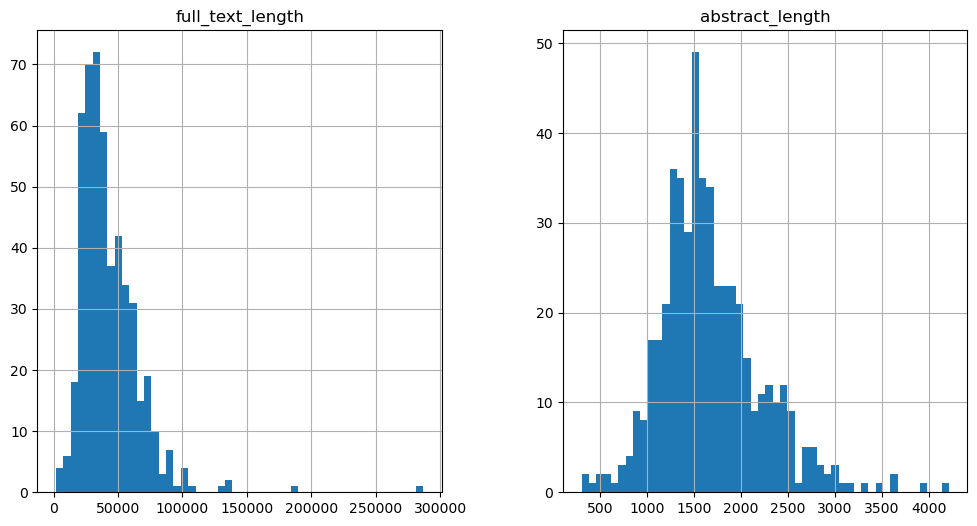

In [36]:
# create two lists 'full_text_length' and 'abstract_length' to store the length of each article and its abstract
full_text_length = []
abstract_length = []

# iterate through each row in the DataFrame
for index, row in df_articles.iterrows():
    # calculate the length of the 'full_text' and 'ABSTRACT' columns
    full_text_length.append(len(row["full_text"]))
    abstract_length.append(len(row["ABSTRACT"]))

data = pd.DataFrame([full_text_length, abstract_length]).T
data.columns = ["full_text_length", "abstract_length"]

data.hist(bins=50, figsize=(12, 6))

In [37]:
# Average length of full_text
data["full_text_length"].mean()
# Average length of abstract
data["abstract_length"].mean()

print("Average length of full_text:", data["full_text_length"].mean())
print("Average length of abstract:", data["abstract_length"].mean())

Average length of full_text: 42918.23
Average length of abstract: 1677.278


In [38]:
# Check for GPU support on Windows/Linux (CUDA) or MacOS (MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [ ]:
# Get a random index from the DataFrame
index = df_articles.sample().index[0]
# Get the full text of the article at the random index
article = df_articles.loc[index, "full_text"]
abstract = df_articles.loc[index, "ABSTRACT"]

22310

In [42]:
print("Article:")
print(wrapper.fill(article))

Article:
Quercetin as one of the most abundant represented biological valuable plant
components with remarkable chemoprotective effects - A review Introduction, The
diversity and quantity of so-called lifestyle diseases are rising quickly due to
detrimental changes in both the modern world's lifestyle and environment.
Several factors, including poor eating habits and food composition that includes
an excessive intake of energy, a high intake of fats, carbohydrates, and salt,
as well as a deficiency in fibre and vitamins, are contributing to this harmful
phenomenon. Not only should doctors and nutrition experts strive to improve the
situation by educating the public more thoroughly, but food manufacturers should
also make a point of offering their products with higher declared concentrations
of positively acting and biologically active substances. The subject of global
debate in recent years become a polyphenolic substance. Higher plants contain
thousands of molecules with a polyphenol 

In [43]:
print("Abstract:")
print(wrapper.fill(abstract))

Abstract:
As a consequence of environmental quality changes as well as changes in our
population's lifestyle, there is rapidly increasing variability and many
so-called lifestyle disorders, allergies, and food intolerances (also known as
non-allergic food hypersensitivity). Unhealthy eating practices, an
inappropriate food composition with an excessive energy intake, a high intake of
saturated fats, simple sugars, and salt, as well as an inadequate intake of
fibre, vitamins, and substances with preventive effects (such as antioxidants),
are some of the factors causing this detrimental phenomenon. Enhanced
consumption of plant foods rich in valuable secondary metabolites such as
phenolic acids and flavonoids with the benefit on human health, food research
focused on these components, and production of foods with declared higher
content of biologically active and prophylactic substances are some ways how to
change and improve this situation. A unique class of hydroxylated phenolic
compou

In [44]:
# find the number of tokens in the article
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
tokens = tokenizer(article, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the article:", num_tokens)

Number of tokens in the article: 5022


In [45]:
# find the number of tokens in the abstract
tokens = tokenizer(abstract, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the abstract:", num_tokens)

Number of tokens in the abstract: 272


In [46]:
def summarize_article_with_model(
    article: str,
    model_name: str = "t5-small",
    max_length: int = 512,
    overlap: int = 128,
    redundancy_threshold: float = 0.8,
    summary_length: int = 300,
) -> str:
    """
    Summarizes an article using a specified model and the sliding window summarization method.

    Args:
        article (str): The article to summarize.
        model_name (str): The model name to use for summarization (default is 't5-small').
        max_length (int): Maximum token length for each chunk (default is 512).
        overlap (int): The number of tokens to overlap between chunks (default is 128).
        redundancy_threshold (float): The cosine similarity threshold for redundancy reduction (default is 0.8).
        summary_length (int): The maximum length of the summary (default is 100 characters).

    Returns:
        str: The summarized article.
    """
    # Initialize tokenizer and pipeline for summarization
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    summarization_pipeline = pipeline("summarization", model=model_name)

    # Call the sliding window summarization function
    summary = sliding_window_summarization(
        text=article,
        tokenizer=tokenizer,
        pipe=summarization_pipeline,
        max_length=max_length,
        overlap=overlap,
        redundancy_threshold=redundancy_threshold,
        summary_length=summary_length,
    )

    return summary

In [58]:
# Summarize the article using the BART model
model_name = "facebook/bart-large-cnn"

# Iitialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Skipping redundant summary (similarity 0.927)
Skipping redundant summary (similarity 0.974)
Summary:
Quercetin is one of the most abundant represented biological valuable plant
components with remarkable chemoprotective effects. The food industry faces a
challenge due to the high antioxidant activity of plant phenolic compounds.
Increased production of polyphenols in the plant responds to causes of stress. A
class of plant metabolites known as flavonoids are believed to have antioxidant
properties and to improve cell signaling pathways. All used articles are
published and reviewed by several experts in the field. Summarization of the
articles took place based on the use of the same methodologies for determining
the content of individual components. Flavonoids are secondary metabolites
present in a range of plants that play a crucial part in the plant's ability to
survive. The most significant subclass of flavonoids is called flavones.


In [59]:
# Evaluate the BART model on the first article
rouge = evaluate.load("rouge")
bart_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bart_scores)

{'rouge1': 0.23980815347721818, 'rouge2': 0.024096385542168676, 'rougeL': 0.13429256594724223, 'rougeLsum': 0.13429256594724223}


In [ ]:
# Summarize an article using the Falconsai/medical_summarization
model_name = "Falconsai/medical_summarization"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (5521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


Skipping redundant summary (similarity 0.839)
Skipping redundant summary (similarity 0.844)
Skipping redundant summary (similarity 0.875)


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


Skipping redundant summary (similarity 0.866)
Summary:
quercetin as one of the most abundant represented biological valuable plant
components with remarkable chemoprotective effects is rising rapidly due to
detrimental changes in both the modern world's lifestyle and environment .
several factors, including poor eating habits and food composition that includes
an excessive intake of energy, a high intake of fats, carbohydrates, and salt,
as well as a deficiency in fibre and vitamins, are contributing to this harmful
phenomenon . the food industry faces a challenge due to the high antioxidant
activity of plant phenolic compounds . flavonoids are secondary metabolites
present in a range of plants that play a crucial role in the plant's ability to
survive by carrying out physiological functions and withstanding negative
environmental effects .


In [61]:
# Evaluate the Falconsai/medical_summarization model on the first article
falconsai_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(falconsai_scores)

{'rouge1': 0.1769041769041769, 'rouge2': 0.014814814814814817, 'rougeL': 0.113022113022113, 'rougeLsum': 0.113022113022113}


In [65]:
# Summarize an article using the "google/bigbird-pegasus-large-pubmed" model
model_name = "google/bigbird-pegasus-large-pubmed"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=3968,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (4603 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 3963 to 3968 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 892 to 896 to be a multiple of `config.block_size`: 64


Summary:
flavonoids are among the most abundant group of natural plant compounds and are
known for their wide range of biological activities , including immunomodulatory
, antitumor , antioxidant , and antiinflammatory properties .<n> quercetin is
one of the most well known flavonoids and is present in many plants , such as
fruits , vegetables , and grains , and has been reported to have a wide range of
biological activities . quercetin is a member of the serine / threonine glycosyl
group family of anti - inflammatory compounds .<n> it is well known for its
humoral and cellular immunomodulatory effects .<n> it also exhibits therapeutic
properties against several diseases , such as cancer , diabetes , and
neurodegenerative disorders .<n> quercetin exhibits poor solubility in aqueous
medium , which is a major reason for its low bioavailability in the food
industry .


In [66]:
# Evaluate the "google/bigbird-pegasus-large-pubmed" model on the first article
bigbird_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bigbird_scores)

{'rouge1': 0.1932367149758454, 'rouge2': 0.014563106796116504, 'rougeL': 0.12077294685990338, 'rougeLsum': 0.12077294685990338}


In [ ]:
# Summarize all articles using the google/bigbird-pegasus-large-arxiv model
pipe = pipeline(
    "summarization", model="google/bigbird-pegasus-large-arxiv", device=device
)
output = pipe(df["full_text"][0])
summary = output[0]["summary_text"]
print(summary)

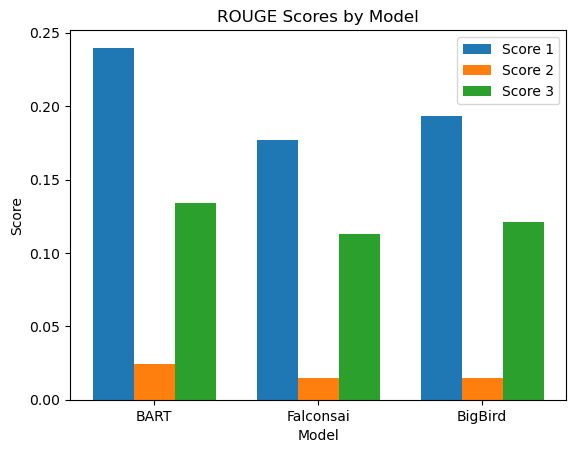

In [67]:
# Create a chart to compare the scores

models = ["BART", "Falconsai", "BigBird"]
scores_1 = [bart_scores["rouge1"], falconsai_scores["rouge1"], bigbird_scores["rouge1"]]
scores_2 = [bart_scores["rouge2"], falconsai_scores["rouge2"], bigbird_scores["rouge2"]]
scores_l = [bart_scores["rougeL"], falconsai_scores["rougeL"], bigbird_scores["rougeL"]]
scores = [scores_1, scores_2, scores_l]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(models))

for i, score in enumerate(scores):
    ax.bar([x + bar_width * i for x in index], score, bar_width, label=f"Score {i + 1}")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("ROUGE Scores by Model")
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [68]:
# extract the article_id, abstract, and full_text columns into a new DataFrame
df_nlp = df_articles[["article_id", "full_text", "ABSTRACT"]]
df_nlp.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [ ]:
# save the dataframe to a .csv file
df_nlp.to_csv("articles.csv", index=False)

In [ ]:
X = df_nlp["full_text"]
y = df_nlp["ABSTRACT"]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## To do: Fine-tuning LLM for our use case
